In [2]:
%cd '/content/drive/MyDrive/Question Generation/data/squad/objective_output/ranking/'

import json
from tqdm.notebook import tqdm
import numpy as np

/content/drive/MyDrive/Question Generation/data/squad/objective_output/ranking


In [3]:
def getPrecisionRecall(ranking_output):
  model_precision = 0
  model_recall = 0
  tfidf_precision = 0
  tfidf_recall = 0
  PR_dict = dict()
  PR_dict['top50docs'] = [] 
  PR_dict['tfidf_top50'] = [] 
  AP_dict = dict()
  AP_dict['top50docs'] = [] 
  AP_dict['tfidf_top50'] = [] 
  for model in ['top50docs', 'tfidf_top50']:
    average_precision = 0
    precision_total = 0
    recall_total = 0
    
    for qidInfo in ranking_output['queries']:
        PR_dict[model].append({'precision':[],'recall':[]})
        num_relevant = 0
        for i, docInfo in enumerate(qidInfo[model]):
          k = i+1
          if docInfo[0] in qidInfo['relevant_cids']:
            num_relevant += 1
            average_precision += num_relevant/k
            precision = num_relevant/k
            recall = num_relevant/len(qidInfo['relevant_cids'])
            PR_dict[model][-1]['precision'].append(precision)
            PR_dict[model][-1]['recall'].append(recall)
        
        AP_dict[model].append(average_precision/len(qidInfo['relevant_cids']))
  return PR_dict, AP_dict

In [4]:
def getPiecewiseLine(PR_dict):
  for model in ['top50docs', 'tfidf_top50']:
    for qidPR in PR_dict[model]:
      final_precision = []
      final_recall = []
      precision = qidPR['precision']
      recall = qidPR['recall']
      if precision == []:
        print("Empty Precision")
        final_precision.append(0)
        final_recall.append(0)
      else:
        next_highest_precision_i = precision.index(max(precision))
        final_precision.append(precision[next_highest_precision_i])
        final_recall.append(recall[next_highest_precision_i])
        precision = precision[next_highest_precision_i+1:]
        recall = recall[next_highest_precision_i+1:]
      while len(precision) > 0:
        next_highest_precision_i = precision.index(max(precision))
        final_precision.append(precision[next_highest_precision_i])
        final_recall.append(final_recall[-1])
        final_precision.append(precision[next_highest_precision_i])
        final_recall.append(recall[next_highest_precision_i])
        precision = precision[next_highest_precision_i+1:]
        recall = recall[next_highest_precision_i+1:]
      qidPR['pr_line'] = (final_recall,final_precision)
  return PR_dict

In [5]:
def getAverage(PR_dict):
  for model in ['top50docs', 'tfidf_top50']:
    recall_final = np.linspace(0.0, 0.050, num=51, endpoint=True)
    precision_total = np.zeros(recall_final.shape)
    for qidPR in PR_dict[model]:
      recall, precision = qidPR['pr_line']
      
      pr_pointer = 0
      for i,r_val in enumerate(recall_final):
        added = False
        while not added:
          if pr_pointer >= len(precision):
              precision_total[i] += 0
              added = True
          elif r_val <= recall[pr_pointer]:
            precision_total[i] += precision[pr_pointer]
            added = True
          else:
            pr_pointer += 1
      # raise
    PR_dict[model + '_avg_pr_line'] = (recall_final,precision_total/len(PR_dict[model]))
  return PR_dict

In [8]:
import matplotlib.pyplot as plt
def showGraphs(ranking_output_test,ranking_output_train, fname_test, fname_train):
    precision_recall, average_precision_test = getPrecisionRecall(ranking_output_test)
    precision_recall = getPiecewiseLine(precision_recall)
    precision_recall = getAverage(precision_recall)
    plt.figure()
    recall,precision = precision_recall['top50docs' + '_avg_pr_line']
    # plt.scatter(recall, precision,marker='x',color='black')
    plt.plot(recall, precision, label='InfoHCVAE Model')
    recall,precision = precision_recall['tfidf_top50' + '_avg_pr_line']
    plt.plot(recall,precision, label='Tf-IDf')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0,1])
    plt.title('Precision-Recall Curve Comparison on Test Set')
    plt.legend()
    plt.savefig(f'images/{fname_test}', format='svg')
    plt.show()
    print("Average Precision for Model on test set: ", sum(average_precision_test['top50docs'])/len(average_precision_test['top50docs']))
    print("Average Precision for Tf-IDf on test set: ", sum(average_precision_test['tfidf_top50'])/len(average_precision_test['tfidf_top50']))

    precision_recall, average_precision_train = getPrecisionRecall(ranking_output_train)
    precision_recall = getPiecewiseLine(precision_recall)
    precision_recall = getAverage(precision_recall)
    plt.figure()
    recall,precision = precision_recall['top50docs' + '_avg_pr_line']
    # plt.scatter(recall, precision,marker='x',color='black')
    plt.plot(recall, precision, label='InfoHCVAE Model')
    recall,precision = precision_recall['tfidf_top50' + '_avg_pr_line']
    plt.plot(recall,precision, label='Tf-IDf')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0,1])
    plt.title('Precision-Recall Curve Comparison on Train Set')
    plt.legend()
    plt.savefig(f'images/{fname_train}', format='svg')
    plt.show()
    print("Average Precision for Model on train set: ", sum(average_precision_train['top50docs'])/len(average_precision_train['top50docs']))
    print("Average Precision for Tf-IDf on train set: ", sum(average_precision_train['tfidf_top50'])/len(average_precision_train['tfidf_top50']))



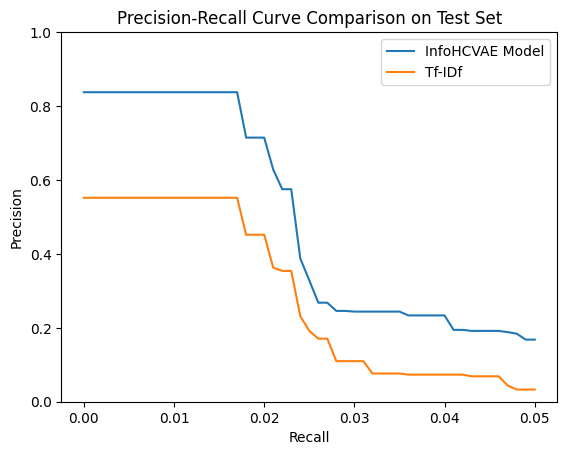

Average Precision for Model on test set:  0.23759274376324332
Average Precision for Tf-IDf on test set:  0.13829597952760359


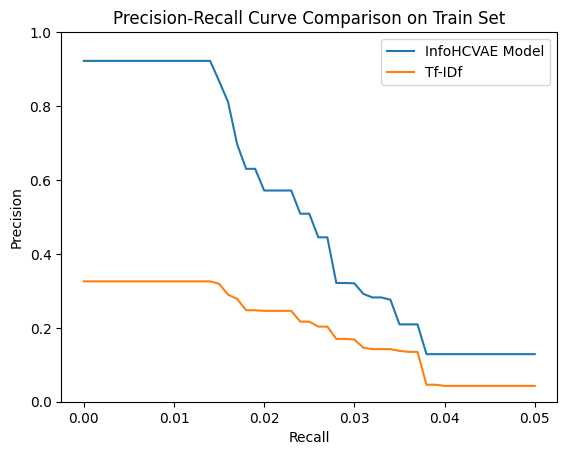

Average Precision for Model on train set:  0.23316517056892888
Average Precision for Tf-IDf on train set:  0.08470225480864726


In [10]:
rank_mode = ['givenAnswer', 'noAnswer'][0]
score_mode = ['rec', 'all'][0]

with open(f'{rank_mode}/test/{score_mode}/ranking_output3.json') as f:
  ranking_output_test = json.load(f)

with open(f'{rank_mode}/train/{score_mode}/ranking_output3.json') as f:
  ranking_output_train = json.load(f)

showGraphs(ranking_output_test,ranking_output_train, fname_test=f'M5_{rank_mode}_{score_mode}_test.svg', fname_train=f'M5_{rank_mode}_{score_mode}_train.svg')

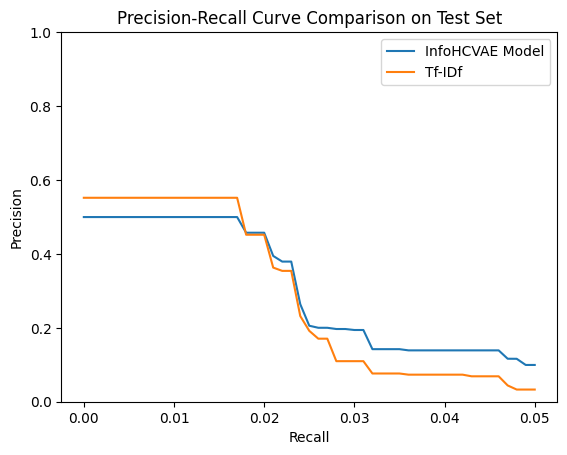

Average Precision for Model on test set:  0.15845109377223332
Average Precision for Tf-IDf on test set:  0.13829597952760359
Empty Precision


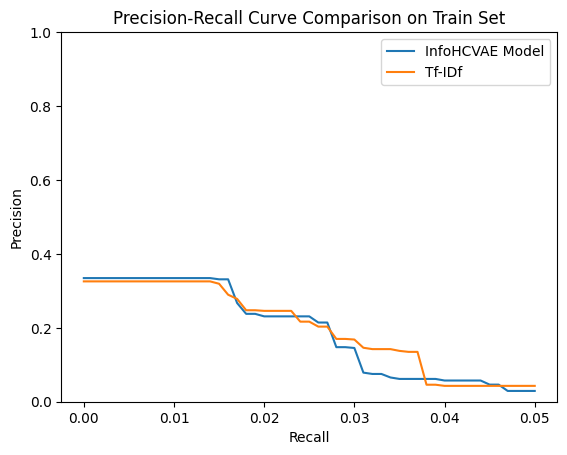

Average Precision for Model on train set:  0.07587833517698285
Average Precision for Tf-IDf on train set:  0.08470225480864726


In [11]:
rank_mode = ['givenAnswer', 'noAnswer'][0]
score_mode = ['rec', 'all'][1]

with open(f'{rank_mode}/test/{score_mode}/ranking_output3.json') as f:
  ranking_output_test = json.load(f)

with open(f'{rank_mode}/train/{score_mode}/ranking_output3.json') as f:
  ranking_output_train = json.load(f)

showGraphs(ranking_output_test,ranking_output_train, fname_test=f'M5_{rank_mode}_{score_mode}_test.svg', fname_train=f'M5_{rank_mode}_{score_mode}_train.svg')

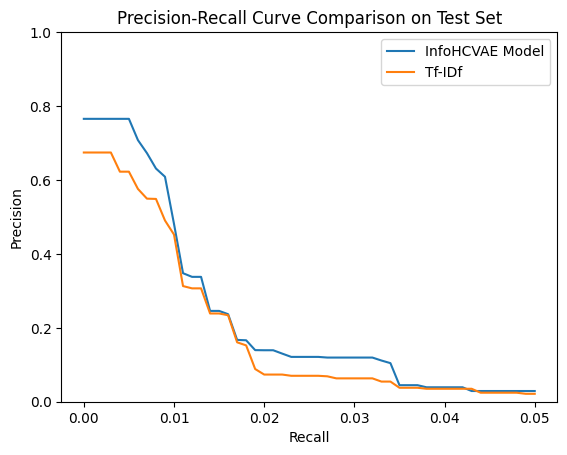

Average Precision for Model on test set:  0.08538144192223983
Average Precision for Tf-IDf on test set:  0.07121221273464187


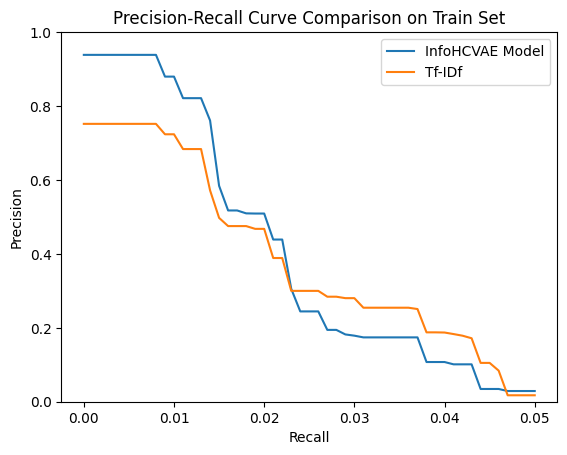

Average Precision for Model on train set:  0.19514736692731152
Average Precision for Tf-IDf on train set:  0.18534637945854046


In [13]:
rank_mode = ['givenAnswer', 'noAnswer'][1]
score_mode = ['rec', 'all'][0]

with open(f'../ranking_old/{rank_mode}/test/{score_mode}/ranking_output3.json') as f:
  ranking_output_test = json.load(f)

with open(f'../ranking_old/{rank_mode}/train/{score_mode}/ranking_output3.json') as f:
  ranking_output_train = json.load(f)

showGraphs(ranking_output_test,ranking_output_train, fname_test=f'M5_{rank_mode}_{score_mode}_test.svg', fname_train=f'M5_{rank_mode}_{score_mode}_train.svg')

Empty Precision


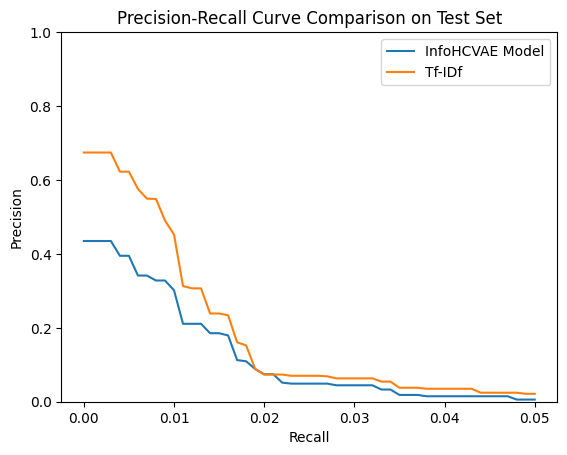

Average Precision for Model on test set:  0.051848372527361075
Average Precision for Tf-IDf on test set:  0.07121221273464187


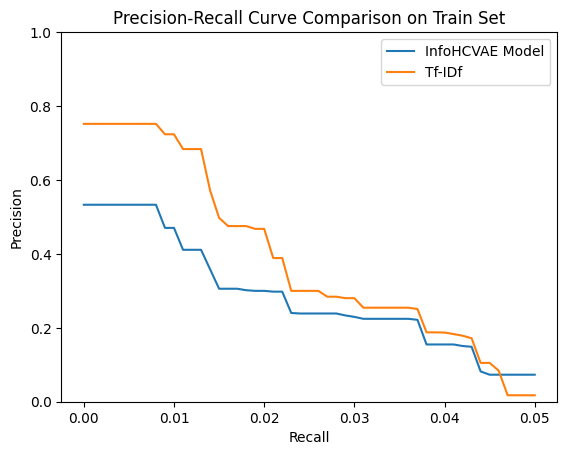

Average Precision for Model on train set:  0.16292310838265728
Average Precision for Tf-IDf on train set:  0.18534637945854046


In [14]:
rank_mode = ['givenAnswer', 'noAnswer'][1]
score_mode = ['rec', 'all'][1]

with open(f'../ranking_old/{rank_mode}/test/{score_mode}/ranking_output3.json') as f:
  ranking_output_test = json.load(f)

with open(f'../ranking_old/{rank_mode}/train/{score_mode}/ranking_output3.json') as f:
  ranking_output_train = json.load(f)

showGraphs(ranking_output_test,ranking_output_train, fname_test=f'M5_{rank_mode}_{score_mode}_test.svg', fname_train=f'M5_{rank_mode}_{score_mode}_train.svg')

In [ ]:
import pandas as pd
rank_mode = ['givenAnswer', 'noAnswer'][1]
score_mode = ['rec', 'all'][0]

with open(f'../ranking/{rank_mode}/test/{score_mode}/ranking_output3.json') as f:
  ranking_output_test = json.load(f)

precision_recall, average_precision_test = getPrecisionRecall(ranking_output_test)
df = pd.DataFrame(data={'Tf-IDf (A)':average_precision_test['tfidf_top50'], 'Info-HCVAE (B)':average_precision_test['top50docs']})
df['B-A']   = df['Info-HCVAE (B)'] - df['Tf-IDf (A)']
B_A_diff_avg = df.loc[:,'B-A'].mean()
B_A_diff_std = df.loc[:,'B-A'].std()
t_value = (B_A_diff_avg / B_A_diff_std)*np.sqrt(len(df))
print(t_value)

4.260584261290739


In [ ]:
rank_mode = ['givenAnswer', 'noAnswer'][0]
score_mode = ['rec', 'all'][0]

with open(f'../ranking/{rank_mode}/test/{score_mode}/ranking_output3.json') as f:
  ranking_output_test = json.load(f)

precision_recall, average_precision_test = getPrecisionRecall(ranking_output_test)
df = pd.DataFrame(data={'Tf-IDf (A)':average_precision_test['tfidf_top50'], 'Info-HCVAE (B)':average_precision_test['top50docs']})
df['B-A']   = df['Info-HCVAE (B)'] - df['Tf-IDf (A)']
B_A_diff_avg = df.loc[:,'B-A'].mean()
B_A_diff_std = df.loc[:,'B-A'].std()
print("mean: ", B_A_diff_avg)
print("std: ", B_A_diff_std)
t_value = (B_A_diff_avg / B_A_diff_std)*np.sqrt(len(df))
print(t_value)

mean:  0.09929676423563975
std:  0.07458552361200269
5.156157597250269


In [ ]:
"""
|CRITICAL VALUE| FOR 14 degrees of freedom IS 2.977 FOR A 99% CONFIDENCE. (2-tailed)
Hence, sufficient evidence that this system is better than tf-idf for testing data at 99%
"""


'\n|CRITICAL VALUE| FOR 14 degrees of freedom IS 2.624 FOR A 99.9% CONFIDENCE. (1-tailed)\nHence, sufficient evidence that this system is better than tf-idf for training data at 99.9% and testing data at 95%\n'